<a href="https://colab.research.google.com/github/lieson-bit/Data-mining-based-on-machine-learning-methods/blob/main/Regression_analysis_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Регрессионная задача по болезни Паркинсона  

Мы стремимся **предсказать тяжесть болезни Паркинсона** на основе **голосовых характеристик и демографических данных** пациента.  
- **Целевая переменная:** `total_UPDRS` (клиническая оценка степени тяжести заболевания).  
- **Признаки:** акустические показатели речи (например, Jitter, Shimmer, NHR, RPDE, PPE) + возраст + пол.  
- **Почему регрессия?** `total_UPDRS` — это непрерывная величина, поэтому задача относится к регрессии, а не классификации.  

✅ Цель: построить модель, которая по этим признакам сможет **оценивать тяжесть Паркинсона** и помогать в раннем мониторинге.  


In [7]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LSTM, Bidirectional, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.base import BaseEstimator, TransformerMixin
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# === Set random seeds for reproducibility ===
np.random.seed(42)
tf.random.set_seed(42)

## 📁 1. Mount Google Drive

Mount Google Drive to access the dataset stored in the cloud. This allows seamless data loading directly into the notebook.

In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 🗃️ 2. Load Dataset

Load the CSV file into a Pandas DataFrame for easy manipulation and exploration.

In [9]:
data_path = "/content/drive/MyDrive/V5.csv"
df = pd.read_csv(data_path)

print("✅ Dataset successfully loaded!")

✅ Dataset successfully loaded!


## 📊 3. Initial Exploration

Display the dataset’s shape, columns, missing values, and first few rows to understand the data structure.

In [10]:
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nMissing values per column:")
print(df.isnull().sum())

print("\nFirst 5 rows:")
display(df.head())


Shape: (5875, 24)
Columns: ['Unnamed: 0', 'index', 'subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

Missing values per column:
Unnamed: 0          0
index               0
subject#            0
age                 0
sex                 0
test_time           0
motor_UPDRS         0
total_UPDRS         0
Jitter(%)           0
Jitter(Abs)      2931
Jitter:RAP          0
Jitter:PPQ5         0
Jitter:DDP          0
Shimmer             0
Shimmer(dB)         0
Shimmer:APQ3        0
Shimmer:APQ5        0
Shimmer:APQ11       0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
PPE                 0
dtype: int64

First 5 rows:


,Unnamed: 0,index,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,0,0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,2,2,1,72,0,19.6810,28.695,35.389,0.00481,NaN,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,3,3,1,72,0,25.6470,28.905,35.810,0.00528,NaN,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,4,4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


## 📝 4. Main Dataset Summary

Summarize key dataset info: size, number of subjects, features, target column, and missing values.

In [11]:
size_mb = os.path.getsize(data_path) / (1024 * 1024)

print("=== Main Dataset Information ===")
print(f"1️⃣ Dataset size: {size_mb:.2f} MB")
print(f"2️⃣ Number of records: {len(df)}")
print(f"3️⃣ Number of features: {len(df.columns)}")
print(f"4️⃣ Target column: 'total_UPDRS' (dtype: {df['total_UPDRS'].dtype})")
print(f"5️⃣ Categorical feature: 'sex' (binary 0/1)")
print(f"6️⃣ Unique subjects: {df['subject#'].nunique()}")
print(f"7️⃣ Test time span: {df['test_time'].min()} → {df['test_time'].max()}")
print(f"8️⃣ Total missing values: {df.isnull().sum().sum()} "
      f"(mainly in 'Jitter(Abs)': {df['Jitter(Abs)'].isnull().sum()})")


=== Main Dataset Information ===
1️⃣ Dataset size: 0.90 MB
2️⃣ Number of records: 5875
3️⃣ Number of features: 24
4️⃣ Target column: 'total_UPDRS' (dtype: float64)
5️⃣ Categorical feature: 'sex' (binary 0/1)
6️⃣ Unique subjects: 42
7️⃣ Test time span: -4.2625 → 215.49
8️⃣ Total missing values: 2931 (mainly in 'Jitter(Abs)': 2931)


## 🧩 6. Feature Data Types

Check the data types of each column to identify numeric and categorical features.

In [12]:
print("=== Feature Types ===")
print(df.dtypes)


=== Feature Types ===
Unnamed: 0         int64
index              int64
subject#           int64
age                int64
sex                int64
test_time        float64
motor_UPDRS      float64
total_UPDRS      float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
dtype: object


## 🗑 7. Drop Unwanted Columns

Remove the motor_UPDRS column as it is not needed for our analysis.

In [13]:
df = df.drop('motor_UPDRS', axis=1)
print("✅ 'motor_UPDRS' column removed.")


✅ 'motor_UPDRS' column removed.


## 📈 8. Descriptive Statistics

Get a statistical overview of numeric features: mean, std, min, max, and quartiles.

In [14]:
print("=== Dataset Descriptive Statistics ===")
display(df.describe())


=== Dataset Descriptive Statistics ===


,Unnamed: 0,index,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,2944.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,2937.000000,2937.000000,21.494128,64.804936,0.317787,92.863722,29.018942,0.006154,0.000044,0.002987,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,1696.110747,1696.110747,12.372279,8.821524,0.465656,53.445602,10.700283,0.005624,0.000036,0.003124,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,0.000000,0.000000,1.000000,36.000000,0.000000,-4.262500,7.000000,0.000830,0.000002,0.000330,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,1468.500000,1468.500000,10.000000,58.000000,0.000000,46.847500,21.371000,0.003580,0.000023,0.001580,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,2937.000000,2937.000000,22.000000,65.000000,0.000000,91.523000,27.576000,0.004900,0.000035,0.002250,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,4405.500000,4405.500000,33.000000,72.000000,1.000000,138.445000,36.399000,0.006800,0.000053,0.003290,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,5874.000000,5874.000000,42.000000,85.000000,1.000000,215.490000,54.992000,0.099990,0.000396,0.057540,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


# 📊 Сводка описательной статистики

## Общая информация о наборе данных:
- **Объем данных:** 5 875 записей × 23 числовых признаков
- **Целевая переменная:** `total_UPDRS` (общий показатель UPDRS)
- **Речевые параметры:** Jitter, Shimmer, NHR, HNR и другие характеристики речи

## 📈 Демографические характеристики:
- **Количество пациентов:** 42 уникальных субъекта
- **Возрастной диапазон:** от 36 до 85 лет
- **Средний возраст:** ≈65 лет
- **Гендерное распределение:**
  - Бинарная переменная `sex` (0/1)
  - ≈32% участников имеют код 1

## ⏱️ Временные параметры исследования:
- **Продолжительность наблюдения:** от -4.26 до 215.49 единиц времени
- **Среднее время тестирования:** 92.86 единиц
- **Особенности:** большинство измерений сконцентрировано вокруг среднего значения

## 🎯 Анализ целевой переменной (total_UPDRS):
- **Диапазон значений:** от 7 до 54.99 баллов
- **Среднее значение:** 29.02
- **Медиана:** 27.58
- **Распределение:** умеренный разброс с легким правосторонним смещением

## 🔍 Особенности речевых параметров:
- **Типичные значения:** большинство признаков имеют небольшие средние значения
- **Экстремальные значения:** присутствуют значительные максимумы, указывающие на возможные выбросы
- **Полнота данных:** один признак (Jitter(Abs)) содержит ≈50% пропущенных значений

## ✅ Общая оценка качества данных:
- **Числовая чистота:** высокий уровень
- **Вариативность:** умеренная across признаков
- **Пригодность для анализа:** отличная для исследовательского анализа и прогнозного моделирования

## 🚀 Рекомендации для дальнейшей работы:
Набор данных хорошо подходит для:
- Исследовательского анализа временных рядов
- Построения прогнозных моделей
- Сравнения различных алгоритмов машинного обучения
- Изучения взаимосвязей между речевыми параметрами и прогрессированием заболевания

## 📊 9. Distribution of Target Variable

Visualize the distribution of total_UPDRS using a histogram to identify skewness or spread.

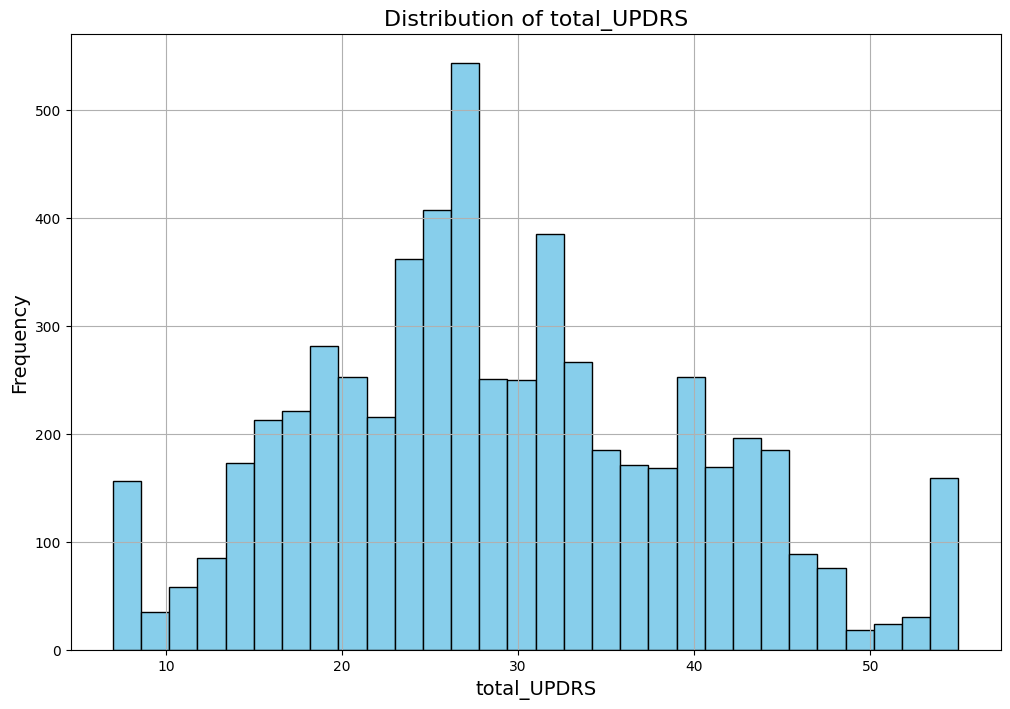

In [15]:
plt.figure(figsize=(12, 8))
df['total_UPDRS'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of total_UPDRS', fontsize=16)
plt.xlabel('total_UPDRS', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


### 🔷 Основные особенности:
- **Форма распределения:** Унимодальное
- **Тип распределения:** Приблизительно нормальное
- **Центр распределения:** Середина 29-х баллов

## 🔗 10. Feature Correlation Matrix

Explore correlations between numeric features. High correlations can indicate redundant features or relationships.

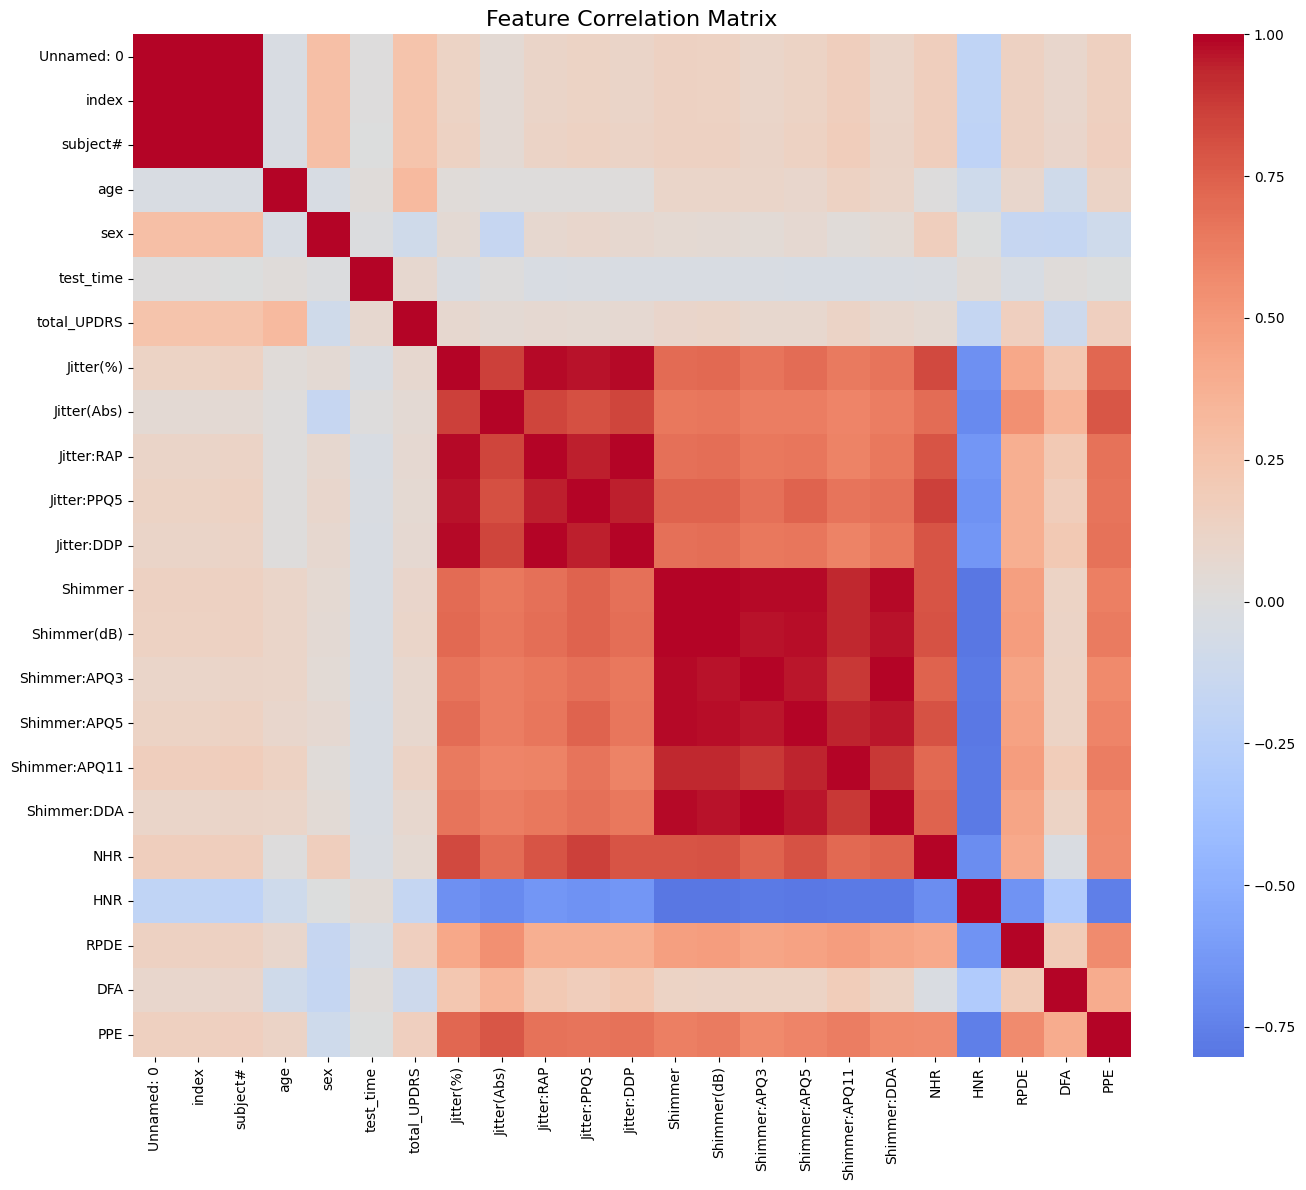

In [16]:
corr_matrix = df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()


# 🔍 Анализ матрицы корреляции признаков

## 📊 Общие наблюдения
- **Тепловая карта** отображает **попарные корреляции** между всеми признаками в наборе данных
- **Диагональ** окрашена в темно-красный цвет (корреляция = 1) - каждый признак идеально коррелирует с самим собой
- **Цветовая схема:** красный = сильная положительная корреляция, синий = сильная отрицательная корреляция, светлые оттенки = слабая корреляция

## 🎯 Ключевые инсайты

### 1. Группы сильно коррелирующих признаков
- **Jitter-параметры** (*Jitter(%), Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP*) демонстрируют сильную положительную корреляцию между собой
- **Shimmer-параметры** (*Shimmer, Shimmer(dB), Shimmer:APQ3, APQ5, APQ11, DDA*) образуют второй кластер сильных корреляций
> 👉 Это указывает на **избыточность** - параметры измеряют схожие аспекты вариабельности голоса

### 2. Отрицательные корреляции
- **HNR (отношение сигнал/шум)** показывает **отрицательную корреляцию** с параметрами jitter и shimmer
> 👉 Логическое объяснение: более высокий уровень шума (jitter/shimmer) означает ухудшение качества гармоник (HNR)

### 3. Корреляции с целевой переменной (total_UPDRS)

- **Возраст (age):** 0.5-0.6 🔥
- **Индекс/номер субъекта (index/subject#):** ≈0.4
- **Jitter/Shimmer параметры:** ≈0.2
- **test_time, PPE, RPDE:** ≈0.2

#### 🎯 Нейтральные/слабые корреляции:
- **HNR, DFA, пол (sex):** ≈ -0.01

### 💡 Ключевые инсайты (на основе реальных данных)

### 1. Возраст - главный предиктор
Указывает, что возраст является наиболее значимым фактором

Клиническая интерпретация: болезнь Паркинсона прогрессирует с возрастом

## ⏱ 11. Time-Series Visualization for Random Subjects

Plot total_UPDRS over time for a few random subjects to visualize progression trends.

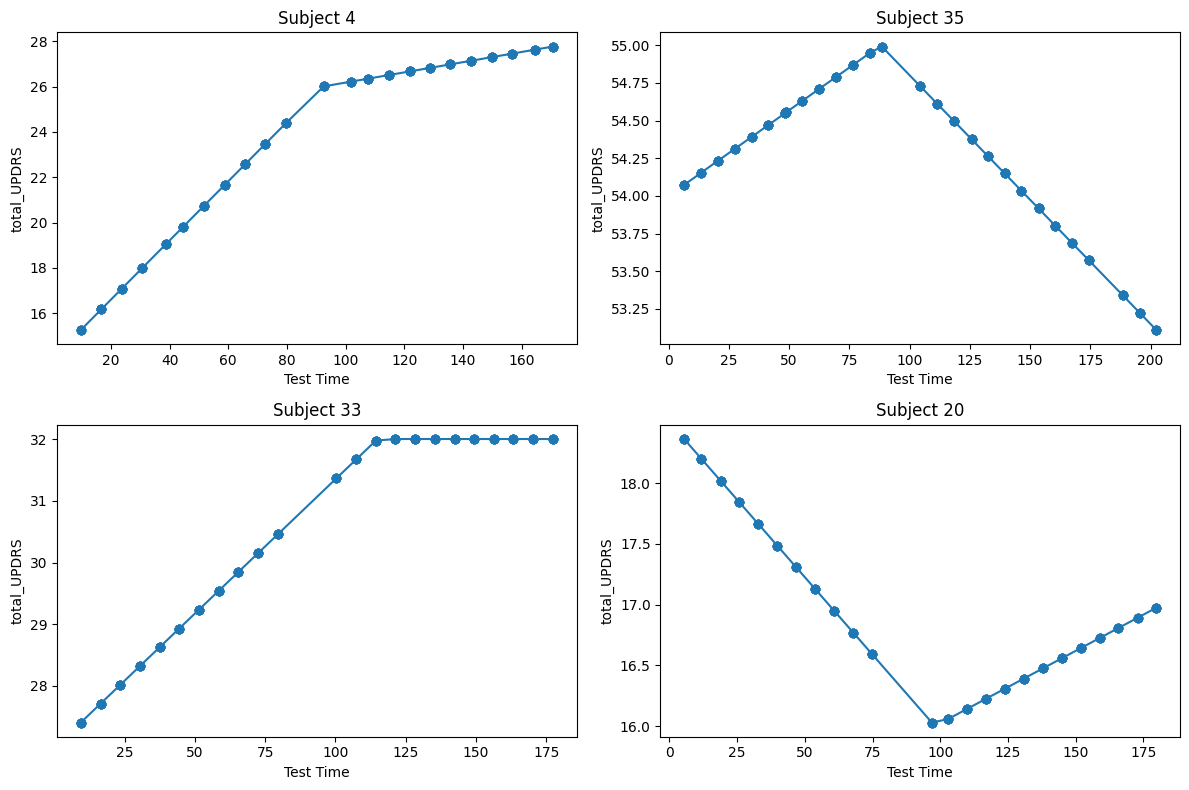

In [19]:
subject_sample = np.random.choice(df['subject#'].unique(), 4, replace=False)
plt.figure(figsize=(12, 8))

for i, subject in enumerate(subject_sample):
    subject_data = df[df['subject#'] == subject].sort_values('test_time')
    plt.subplot(2, 2, i+1)
    plt.plot(subject_data['test_time'], subject_data['total_UPDRS'], marker='o', linestyle='-')
    plt.title(f'Subject {subject}', fontsize=12)
    plt.xlabel('Test Time')
    plt.ylabel('total_UPDRS')

plt.tight_layout()
plt.show()


> **Резюме анализа:**  
> Графики подтверждают, что тяжесть болезни Паркинсона развивается у разных пациентов по-разному.  
> У большинства наблюдается стабильное ухудшение, однако у некоторых отмечаются колебания, что делает важным обучение регрессионной модели на **долгосрочных данных**, а не исходя из универсальной траектории.  
>
> **Клинический смысл:**  
> - Рост `total_UPDRS` = ухудшение симптомов.  
> - Снижение или колебания (например, как у пациента 35) могут указывать на реакцию на лечение, влияние образа жизни или погрешности в сборе данных.  
